# kNN classification of text documents

In [1]:
import numpy as np
import nltk
from nltk import corpus
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
#To access the reuters corpus you will need to run this and download it
# nltk.download()

Let's define the lemmatization process, which in this case will just be tokenization and stemming.  I conclude by constructing the lemmatize function with takes a text document and outputs it as a list of lemmas.

In [3]:
fids = corpus.reuters.fileids()

stemmer = PorterStemmer().stem
print(stemmer("commercially"), stemmer("commercial"))

tokenize = nltk.word_tokenize

def stem(tokens,stemmer = PorterStemmer().stem):
    return [stemmer(w.lower()) for w in tokens] 

def lemmatize(text):
    """
    Extract simple lemmas based on tokenization and stemming
    Input: string
    Output: list of strings (lemmata)
    """
    return stem(tokenize(text))

commerci commerci


Let's look at some elements of our corpus.  The following is a short article about export, and in the next line you can see that it is in the 'trade' category.

In [4]:
corpus.reuters.raw(fids[0])

'ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RIFT\n  Mounting trade friction between the\n  U.S. And Japan has raised fears among many of Asia\'s exporting\n  nations that the row could inflict far-reaching economic\n  damage, businessmen and officials said.\n      They told Reuter correspondents in Asian capitals a U.S.\n  Move against Japan might boost protectionist sentiment in the\n  U.S. And lead to curbs on American imports of their products.\n      But some exporters said that while the conflict would hurt\n  them in the long-run, in the short-term Tokyo\'s loss might be\n  their gain.\n      The U.S. Has said it will impose 300 mln dlrs of tariffs on\n  imports of Japanese electronics goods on April 17, in\n  retaliation for Japan\'s alleged failure to stick to a pact not\n  to sell semiconductors on world markets at below cost.\n      Unofficial Japanese estimates put the impact of the tariffs\n  at 10 billion dlrs and spokesmen for major electronics firms\n  said they would v

In [5]:
corpus.reuters.categories(fids[0])

['trade']

In [6]:
reuters = [corpus.reuters.raw(f) for f in fids]

Quite often you need ways of converting from document ids to integer ids, lemmas to integer ids, and from the lemmas to the documents containing them.  Let's construct the relevant dictionaries.

In [7]:
textd = {} #dictionary from lemmata to document ids containing that lemma
for fid in fids:
    t = corpus.reuters.raw(fid)
    s = set(lemmatize(t))
    try:
        toks = toks | s
    except NameError:
        toks = s
    for tok in s:
        try:
            textd[tok].append(fid)
        except KeyError:
            textd[tok] = [fid]

In [8]:
docids = {} #dictionary of the document id to an integer id for the document
N = len(fids)
for i in range(N):
    docids[fids[i]] = i

In [9]:
tokids = {} #dictionary of lemma to integer id for the lemma
tok_list = list(toks)
m = len(tok_list)
for j in range(m):
    tokids[tok_list[j]] = j

Let's construct the smoothed idf transform.  Let $N$ be the number of documents, and $n(lemma)$ be the number of documents containing the lemma.
$$idf(lemma) = log(N / (1 + n(lemma)))$$

In [10]:
numd = {key:len(set(val)) for key,val in textd.items()}

In [11]:
logN = np.log(len(fids))

In [12]:
idf_smooth = {key:logN - np.log(1 + val) for key, val in numd.items() if val > 1}

In [13]:
idfvals = np.array([v for a,v in idf_smooth.items()])

In [14]:
idfvals

array([ 2.24916207,  0.43954887,  4.66121687, ...,  8.1875774 ,
        8.1875774 ,  8.1875774 ])

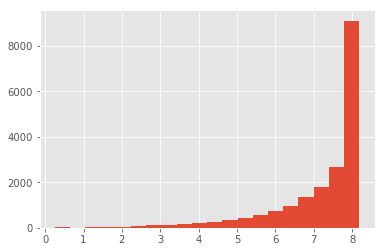

In [15]:
_ = plt.hist(idfvals,bins=20)

In order to form a idf weighted similarity we'll use the built in TfidfVectorizer method from scikit-learn.  This will construct the full tfidf transform as a N times m matrix, where N is the number of documents and m is the number of lemmas.

In [16]:
vectorizer = TfidfVectorizer(tokenizer=lemmatize,stop_words="english",smooth_idf=True,norm=None)

tfs = vectorizer.fit_transform(reuters)

In [17]:
sim = tfs.dot(tfs.T)

In [25]:
tok = tok_list[930]

In [26]:
tok

'verac'

In [27]:
reu_label = [1*('earn' in corpus.reuters.categories(fid)) for fid in fids]

In [28]:
testdocs = [docids[tname] for tname in textd[tok]]

In [29]:
testdocs

[1534, 1604]

In [30]:
print(sim[testdocs[0],testdocs])

  (0, 0)	1504.96115843
  (0, 1)	1602.52774812


In [33]:
print(reuters[testdocs[0]])

BALL CORP &lt;BLL> COMPLETES ACQUISITION OF VERAC
  Ball Corp said it completed the
  acquisition of privately held Verac Inc.
      Terms were not disclosed.
      The company said the San Diego-based defense systems and
  software development company had sales of about 23 mln dlrs in
  1986 and will operate as part of Ball's technical products
  group.
  




In [34]:
print(reuters[testdocs[1]])

BALL CORP &lt;BLL> COMPLETES ACQUISITION
  Ball Corp said it completed the
  purchase of privately held &lt;Verac Inc>, a San Diego defense
  systems and software development company.
      Terms of the acquisition were not disclosed. Verac had 1986
  sales of about 23 mln dlrs.
      Verac will operate in San Diego as part of Ball's technical
  products group.
  




Finally, we can find the nearest neighbors of each document (excluding itself).  Let us define the precision as the percentage of documents classified correctly in this way.

In [58]:
k_max = 20
nbrs = NearestNeighbors(n_neighbors=k_max).fit(tfs)
err_list = []

for k in range(1,k_max+1,2):
    neighmat = nbrs.kneighbors_graph(n_neighbors=k)
    pred_lab = (neighmat.dot(reu_label) > k/2.)*1 #Why should this be knn classification?
    err =  np.mean(pred_lab != reu_label)
    err_list.append(err)

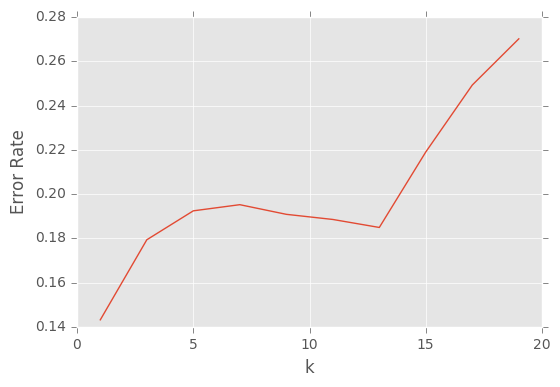

In [59]:
plt.plot(range(1,k_max + 1,2),err_list)
plt.xlabel('k')
plt.ylabel('LOO Error Rate')

Let's also use the bigrams as the tokens for the tfidf nearest neighbor classification.  First, I'll replace the old tokenizer with a bigram version of it.

In [49]:
bigramitize = lambda text: [a + ' ' + b for a,b in nltk.bigrams(lemmatize(text))]

In [50]:
vectorizer = TfidfVectorizer(tokenizer=bigramitize,stop_words="english",smooth_idf=True,norm=None)
bitfs = vectorizer.fit_transform(reuters)

In [55]:
k_max = 20
nbrs = NearestNeighbors(n_neighbors=k_max).fit(bitfs)
err_list = []

for k in xrange(1,k_max+1,2):
    neighmat = nbrs.kneighbors_graph(n_neighbors=k)
    pred_lab = (neighmat.dot(reu_label) > k/2.)*1 
    err =  np.mean(pred_lab != reu_label)
    err_list.append(err)

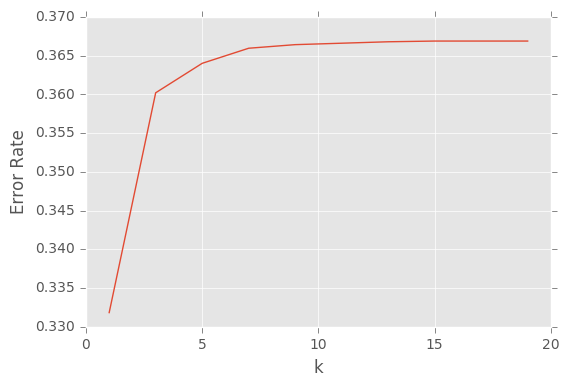

In [56]:
plt.plot(range(1,k_max + 1,2),err_list)
plt.xlabel('k')
plt.ylabel('LOO Error Rate')

The conclusion is that the word content provides a better similarity measure than the bigram content.  This is probably because there is not sufficient overlap between document bigrams.